In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

import csv
import gzip
import os
import scipy.io

# Reading the data

At first, we have to convert the 10X data into AnnData format.

In [2]:
def read_10X_data(matrix_dir, prefix):
    mat = scipy.io.mmread(os.path.join(matrix_dir, prefix+"matrix.mtx.gz"))
    
    features_path = os.path.join(matrix_dir, prefix+"genes.tsv.gz")
    feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, "rt", encoding="utf-8"), delimiter="\t")]
    gene_names = [row[1] for row in csv.reader(gzip.open(features_path, "rt", encoding="utf-8"), delimiter="\t")]
    barcodes_path = os.path.join(matrix_dir, prefix+"barcodes.tsv.gz")
    barcodes = [row[0] for row in csv.reader(gzip.open(barcodes_path, "rt", encoding="utf-8"), delimiter="\t")]
    
    var = pd.DataFrame(data={"ID": feature_ids,"Name": gene_names})
    obs = pd.DataFrame(data={"Name": barcodes})
    adata = sc.AnnData(X = mat.transpose(),
                       var=var,
                       obs=obs)
    
    return adata

In [3]:
home_dir = '/home/jafar_isbarov/Desktop/scRNA-seq/paper_2/GSE143888_RAW/'

stages = ['UA',
          '11dpa',
          '12dpa',
          '14dpa',
          '17dpa']

prefixes = ['GSM4276219_UA_BRI232_',
            'GSM4276220_11dpa_BRI230_',
            'GSM4276221_12dpa_BRI074_',
            'GSM4276222_14dpa_BRI206_',
            'GSM4276223_17dpa_BRI231_']

adatas = []
for final_directory, prefix in zip(stages, prefixes):
    adatas.append(read_10X_data(home_dir+final_directory, prefix=prefix))

/home/jafar_isbarov/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
marker_genes = ['Bglap', 'Krt14', 'Plp1', 'Lyz2', 'Pecam1', 'Rgs5', 'Cd3g', 'Prrx1']

# UA
## Pre-processing

... storing 'Name' as categorical


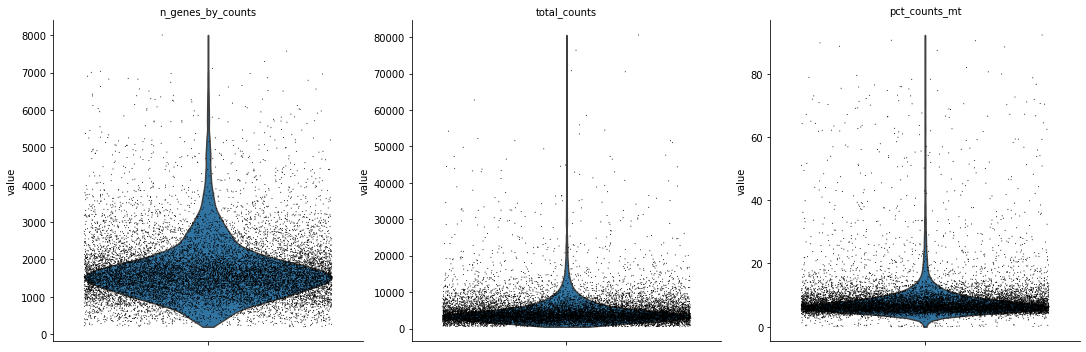

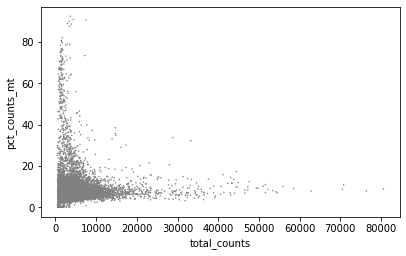

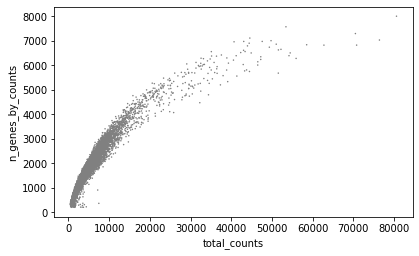

In [5]:
adata_ua = adatas[0].copy()
adata_ua.var_names_make_unique

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_ua.X = adata_ua.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_ua, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_ua, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_ua.var['mt'] = adata_ua.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_ua, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# 
sc.pl.violin(adata_ua, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

# plot logarithmically
sc.pl.scatter(adata_ua, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_ua, x='total_counts', y='n_genes_by_counts')

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


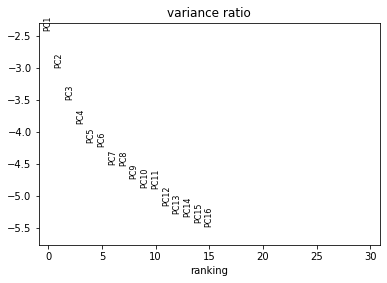

In [6]:
adata_ua.obs['n_genes_by_counts_filter'] = adata_ua.obs.n_genes_by_counts > 1000
adata_ua.obs['pct_counts_mt_filter'] = adata_ua.obs.pct_counts_mt < 20

sc.pp.log1p(adata_ua)
sc.pp.highly_variable_genes(adata_ua, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_ua_hvg = adata_ua[:, adata_ua.var['highly_variable'] == True]
adata_ua_hvg.raw = adata_ua
sc.pp.scale(adata_ua_hvg)
sc.pp.pca(adata_ua_hvg, n_comps=16)
sc.pp.neighbors(adata_ua_hvg)
sc.pl.pca_variance_ratio(adata_ua_hvg, log=True)

## Clustering
As we can see, there is no clustering info for the obs. We will have to perform clustering and add the data.
### Visualizing marker genes
At first we have to locate marker genes, so that we can later find their clusters.

__Interesting:__ _Prrx1_ gene is not among top 3000 HVGs.  

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


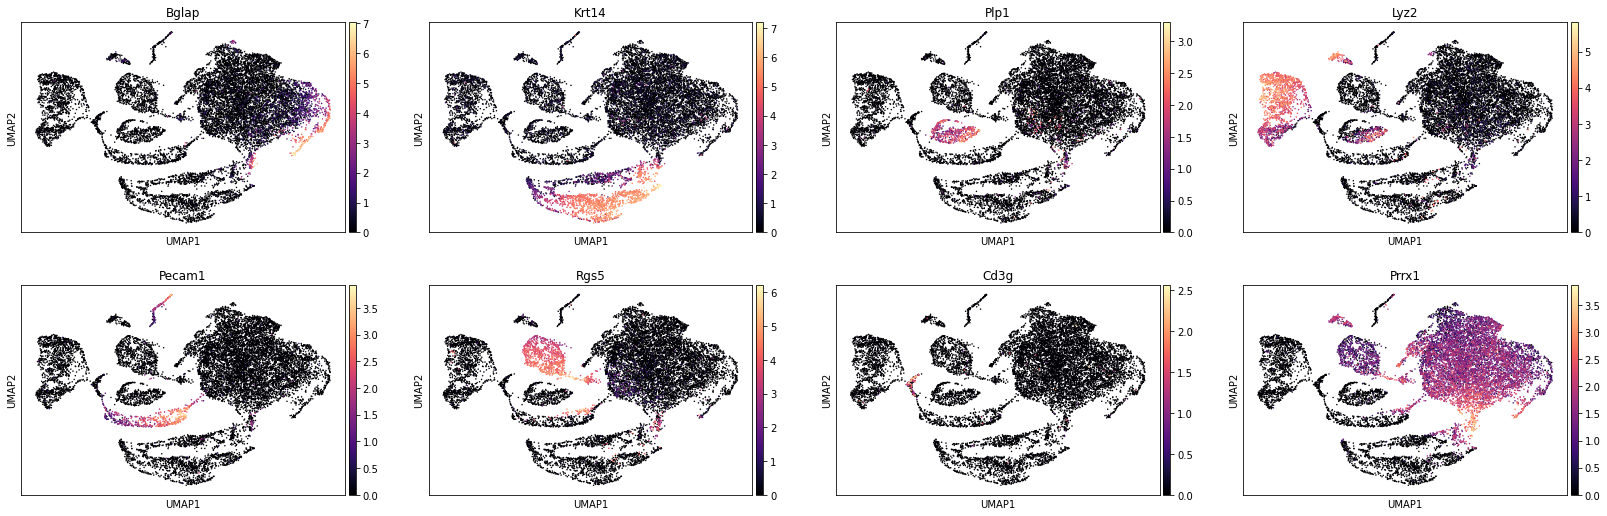

In [7]:
#visualized on adata_ua instead of adata_ua_hvg
sc.pp.pca(adata_ua, n_comps=16)
sc.pp.neighbors(adata_ua)
sc.tl.umap(adata_ua)
sc.pl.umap(adata_ua, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [8]:
# get 21 clusters (see supplements)
sc.tl.leiden(adata_ua_hvg, resolution=0.45)

# add leiden labels to the original data
adata_ua.obs['leiden'] = adata_ua_hvg.obs['leiden']

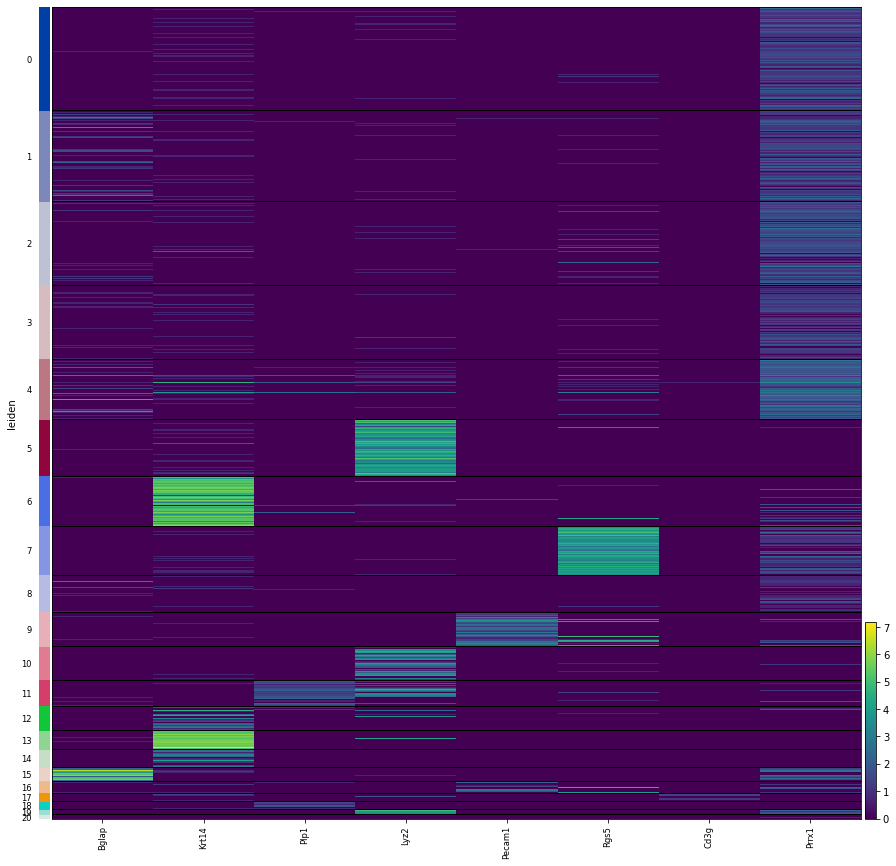

In [9]:
sc.pl.heatmap(adata_ua, gene_symbols='Name', var_names=marker_genes, groupby='leiden', figsize=(15,15))

__gene - cluster(s)__  
Bglap - 15  
Krt14 - 6, 12-14  
Plp1 - 11  
Lyz2 - 19  
Pecam1 - 9  
Rgs5 - 7  
Cd3g - 17  
Prrx1 - 0-4, 6-8, 15, 19

### K-means clustering

Since our `adata.X` is a sparse matrix, we have to use `sklearn.decomposition.TruncatedSVD` instead of `sklearn.decomposition.PCA`.

In [10]:
def explained_variance_ratio(adata):
    tSVD = TruncatedSVD(n_components=100).fit(adata.X)
    plt.plot(np.cumsum(tSVD.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.xlim(0,100)
    plt.show()

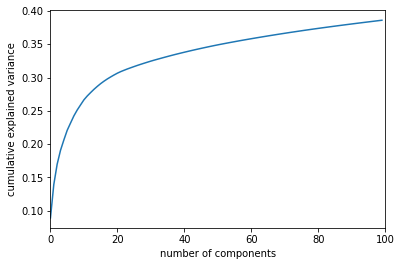

In [11]:
explained_variance_ratio(adata_ua_hvg)

30 is roughly the point of diminishing returns, so we will accept it as the number of components.

In [12]:
reduced_data_ua_hvg = TruncatedSVD(n_components=30).fit_transform(adata_ua_hvg.X)

I will initially use `n_clusters=22`, as this was the number of clusters gained in the paper.

In [13]:
kmeans = KMeans(n_clusters=22, random_state=0).fit(reduced_data_ua_hvg) 
adata_ua.obs['kmeans22'] = kmeans.labels_.astype(str)

... storing 'kmeans22' as categorical


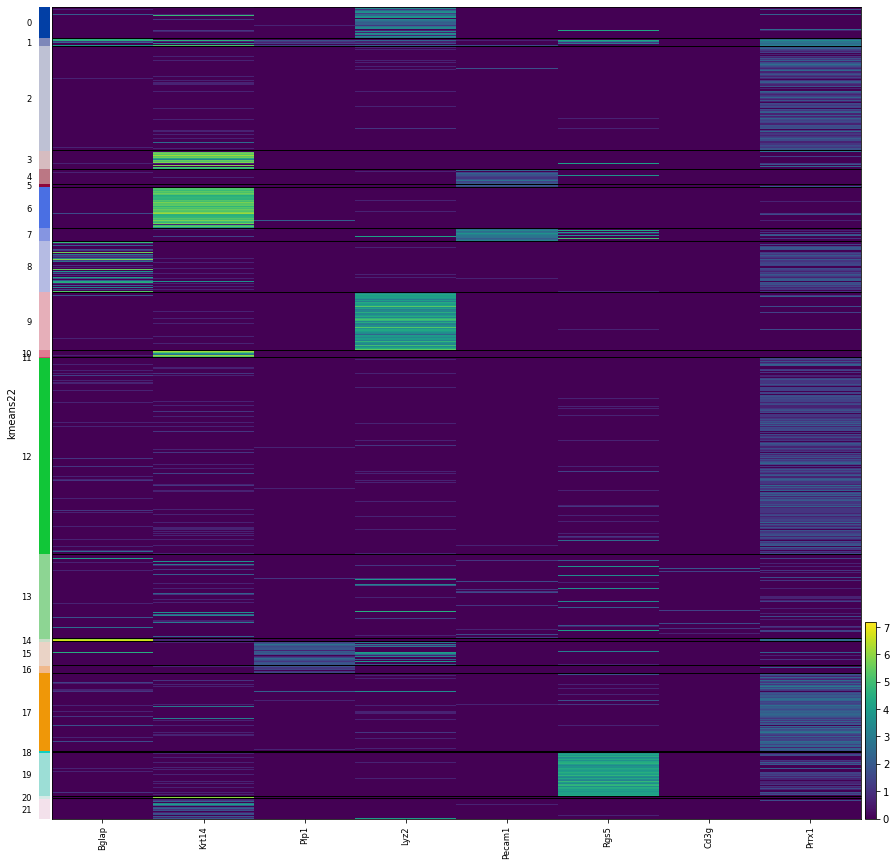

In [14]:
sc.pl.heatmap(adata_ua, gene_symbols='Name', var_names=marker_genes, groupby='kmeans22', figsize=(15,15))

__gene - cluster(s)__  
Bglap - 1, 8, 14  
Krt14 - 1, 3, 6, 10, 20, 21  
Plp1 - 1, 15, 16  
Lyz2 - 0, 9, 15  
Pecam1 - 4, 5, 7  
Rgs5 - 1, 7, 19  
Cd3g - ~
Prrx1 - 2, 8, 12, 14, 17

In [15]:
dir_path = os.path.dirname(os.path.realpath('paper_2.ipynb'))
adata_ua_hvg.write(os.path.join(dir_path, 'adata_ua_hvg'))

# 11dpa
## Pre-processing

... storing 'Name' as categorical


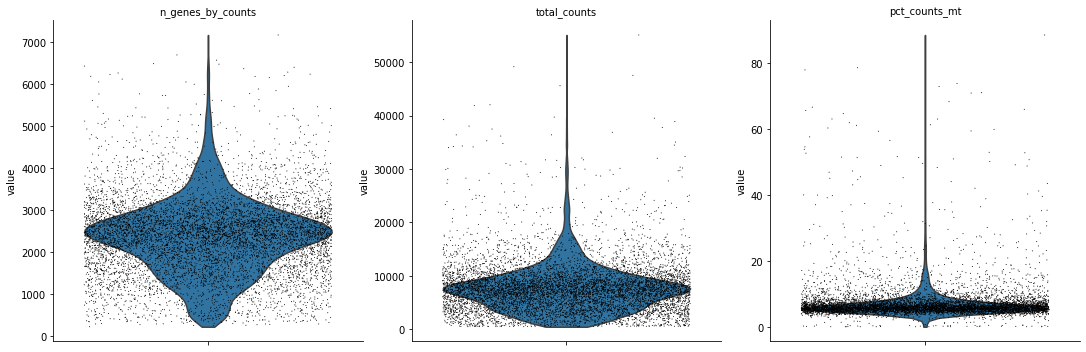

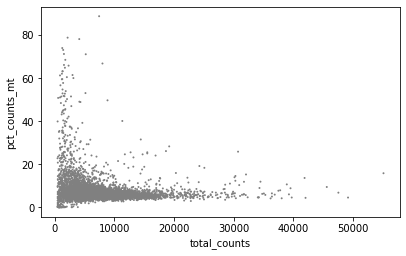

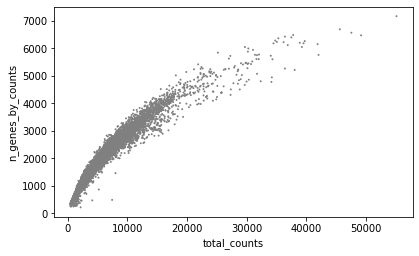

In [16]:
adata_11dpa = adatas[1].copy()
adata_11dpa.var_names_make_unique

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_11dpa.X = adata_11dpa.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_11dpa, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_11dpa, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_11dpa.var['mt'] = adata_11dpa.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_11dpa, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata_11dpa, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_11dpa, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_11dpa, x='total_counts', y='n_genes_by_counts')

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


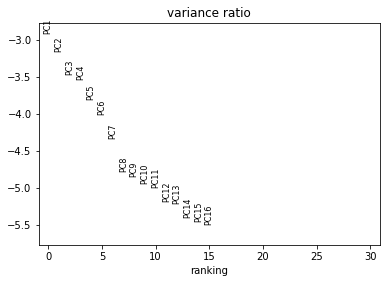

In [17]:
adata_11dpa.obs['n_genes_by_counts_filter'] = adata_11dpa.obs.n_genes_by_counts > 1500
adata_11dpa.obs['pct_counts_mt_filter'] = adata_11dpa.obs.pct_counts_mt < 20

sc.pp.log1p(adata_11dpa)
sc.pp.highly_variable_genes(adata_11dpa, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_11dpa_hvg = adata_11dpa[:, adata_11dpa.var['highly_variable'] == True]
adata_11dpa_hvg.raw = adata_11dpa
sc.pp.scale(adata_11dpa_hvg)
sc.pp.pca(adata_11dpa_hvg, n_comps=16)
sc.pp.neighbors(adata_11dpa_hvg)
sc.pl.pca_variance_ratio(adata_11dpa_hvg, log=True)

## Clustering
### Visualizing marker genes

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


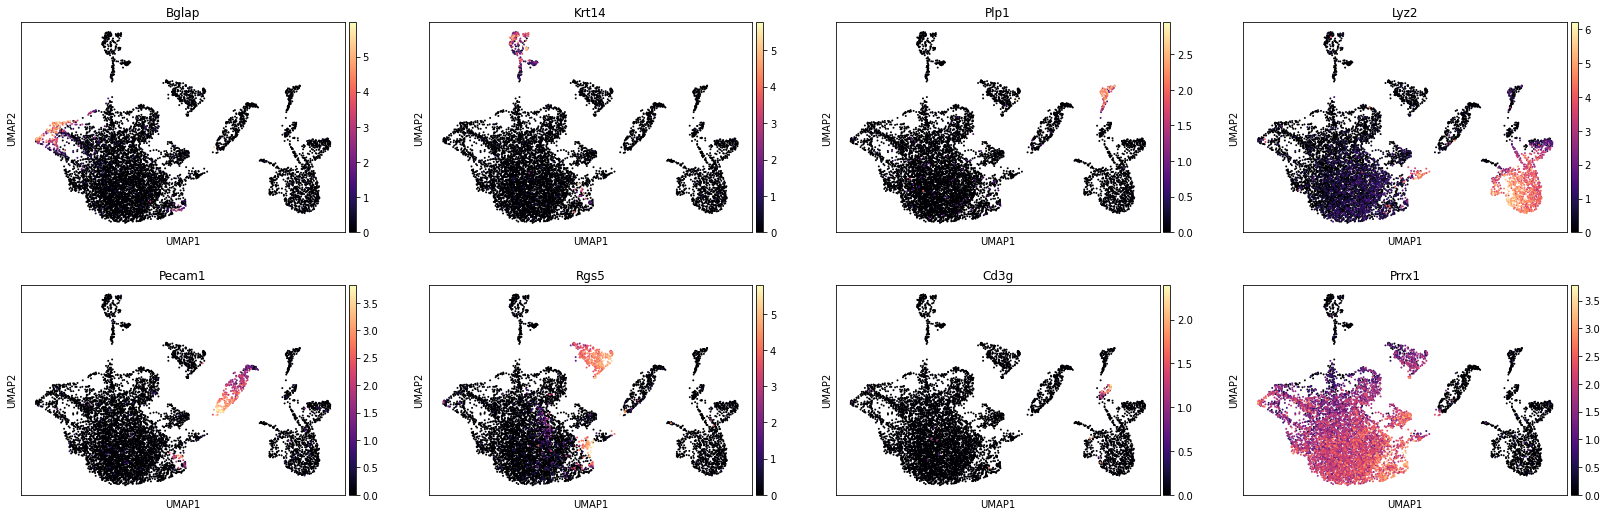

In [18]:
sc.pp.pca(adata_11dpa)
sc.pp.neighbors(adata_11dpa)
sc.tl.umap(adata_11dpa)
sc.pl.umap(adata_11dpa, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [19]:
sc.tl.leiden(adata_11dpa_hvg, resolution=0.6)
adata_11dpa.obs['leiden'] = adata_11dpa_hvg.obs['leiden']

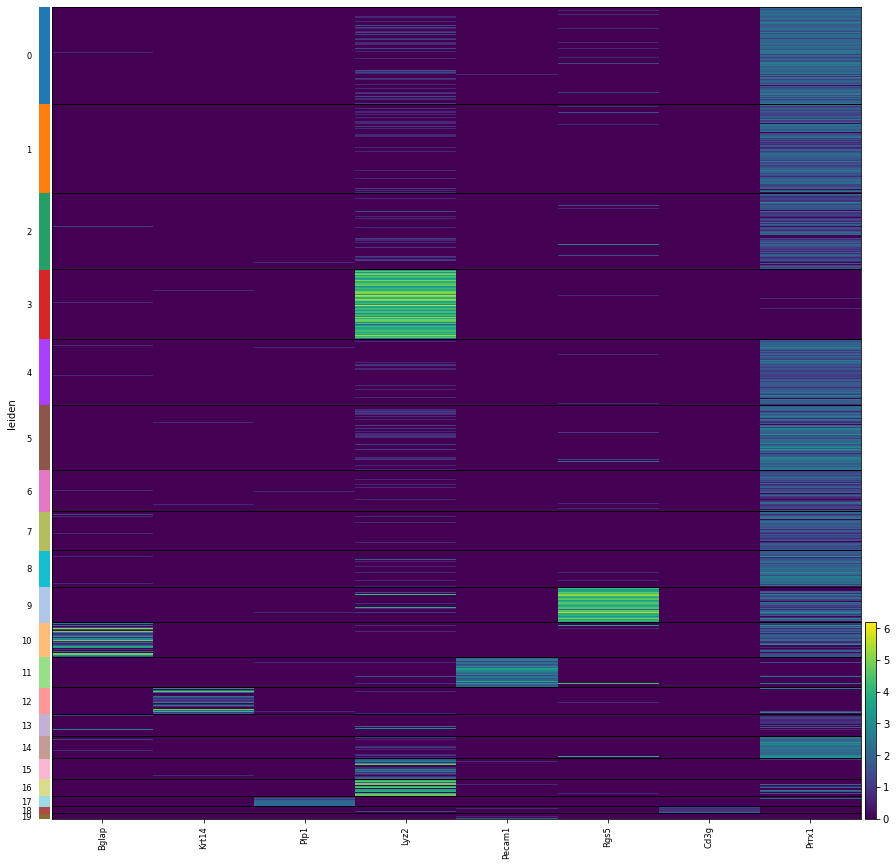

In [20]:
sc.pl.heatmap(adata_11dpa, gene_symbols='Name', var_names=marker_genes, groupby='leiden', figsize=(15,15))

__gene - cluster(s)__   
Bglap - 10  
Krt14 - 12  
Plp1 - 17    
Lyz2 - 3, 15, 16  
Pecam1 - 11  
Rgs5 - 9  
Cd3g - 18 
Prrx1 - 0-2, 4-10, 14, 16

### K-means clustering

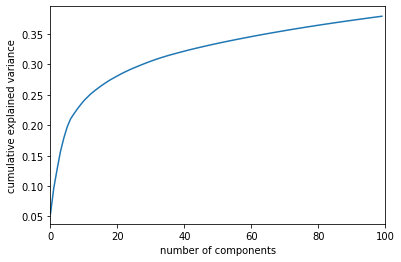

In [21]:
explained_variance_ratio(adata_11dpa_hvg)

30 can be said to be the point of diminishing returns, so take 30 components.

In [22]:
reduced_data_11dpa_hvg = TruncatedSVD(n_components=30).fit_transform(adata_11dpa_hvg.X)

Kmeans:  
Bglap - #6  
Krt14 - #7  
Plp1 - #2  
Lyz2 - #1 #2 #4 #11 #15  
Pecam1 - #5  
Rgs5 - #12  
Cd3g - #10  
Prrx1 - #3 #6 #8 #9 #12 #13 #14 #16

In [23]:
kmeans = KMeans(n_clusters=17, random_state=0).fit(reduced_data_11dpa_hvg) 
adata_11dpa.obs['kmeans17'] = kmeans.labels_.astype(str)

... storing 'kmeans17' as categorical


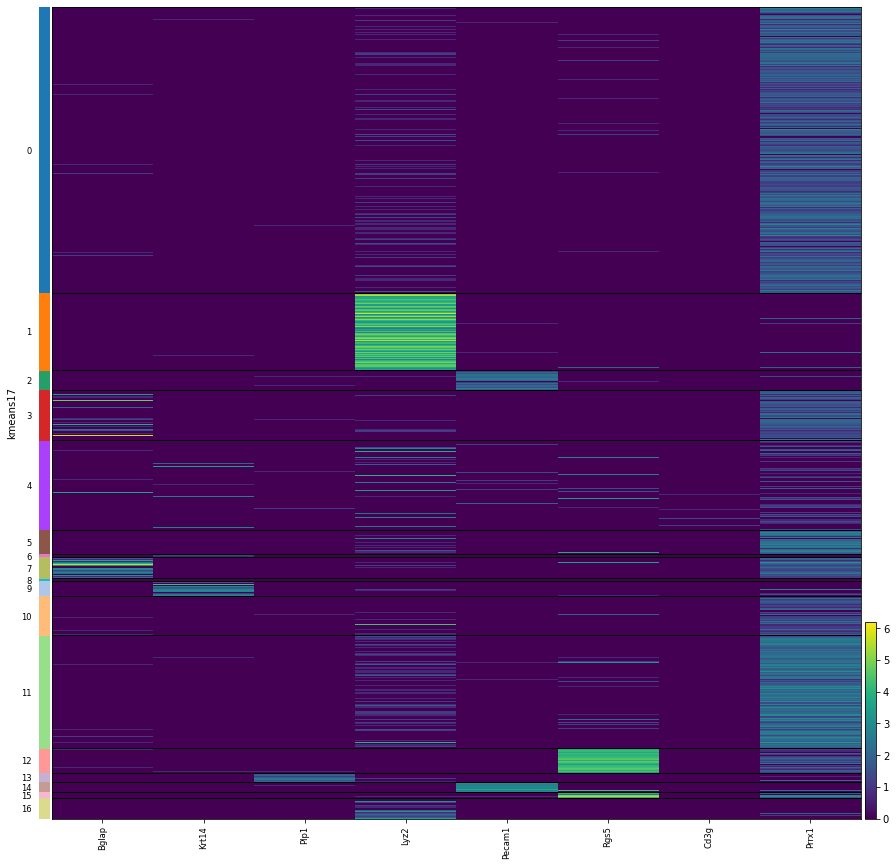

In [24]:
sc.pl.heatmap(adata_11dpa, gene_symbols='Name', var_names=marker_genes, groupby='kmeans17', figsize=(15,15))

__gene - cluster(s)__   
Bglap - 
Krt14 - 
Plp1 -     
Lyz2 -   
Pecam1 -   
Rgs5 -  
Cd3g - 
Prrx1 - 

In [25]:
dir_path = os.path.dirname(os.path.realpath('paper_2.ipynb'))
adata_11dpa_hvg.write(os.path.join(dir_path, 'adata_11dpa_hvg'))

# 12dpa

... storing 'Name' as categorical


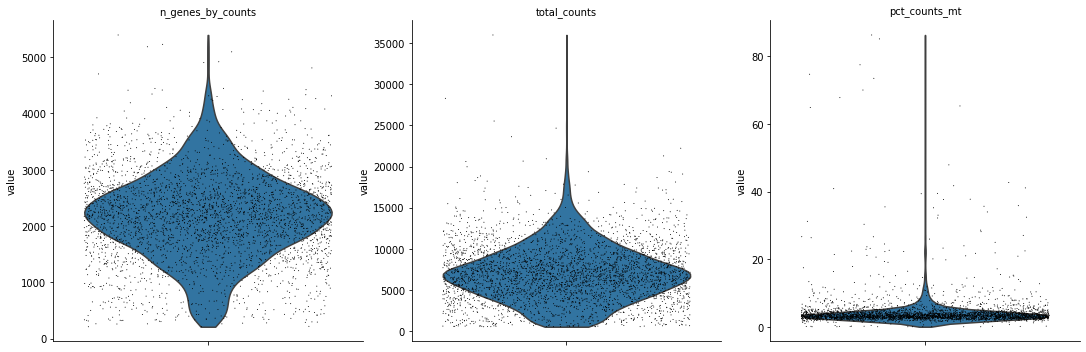

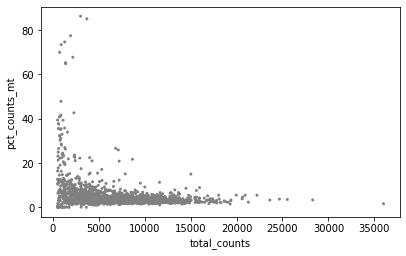

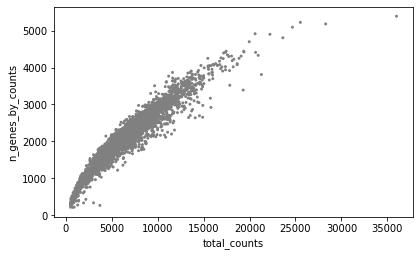

In [26]:
adata_12dpa = adatas[2].copy()
adata_12dpa.var_names_make_unique

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_12dpa.X = adata_12dpa.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_12dpa, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_12dpa, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_12dpa.var['mt'] = adata_12dpa.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_12dpa, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata_12dpa, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_12dpa, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_12dpa, x='total_counts', y='n_genes_by_counts')

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


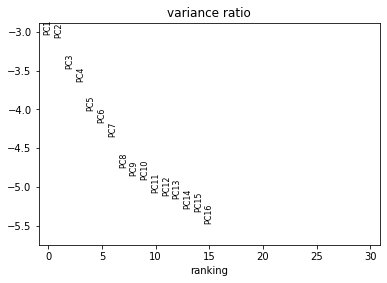

In [27]:
adata_12dpa.obs['n_genes_by_counts_filter'] = adata_12dpa.obs.n_genes_by_counts < 1000
adata_12dpa.obs['pct_counts_mt_filter'] = adata_12dpa.obs.pct_counts_mt < 5

sc.pp.log1p(adata_12dpa)
sc.pp.highly_variable_genes(adata_12dpa, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_12dpa_hvg = adata_12dpa[:, adata_12dpa.var['highly_variable'] == True]
adata_12dpa_hvg.raw = adata_12dpa
sc.pp.scale(adata_12dpa_hvg)
sc.pp.pca(adata_12dpa_hvg, n_comps=16)
sc.pp.neighbors(adata_12dpa_hvg)
sc.pl.pca_variance_ratio(adata_12dpa_hvg, log=True)

## Clustering¶
### Visualizing marker genes

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


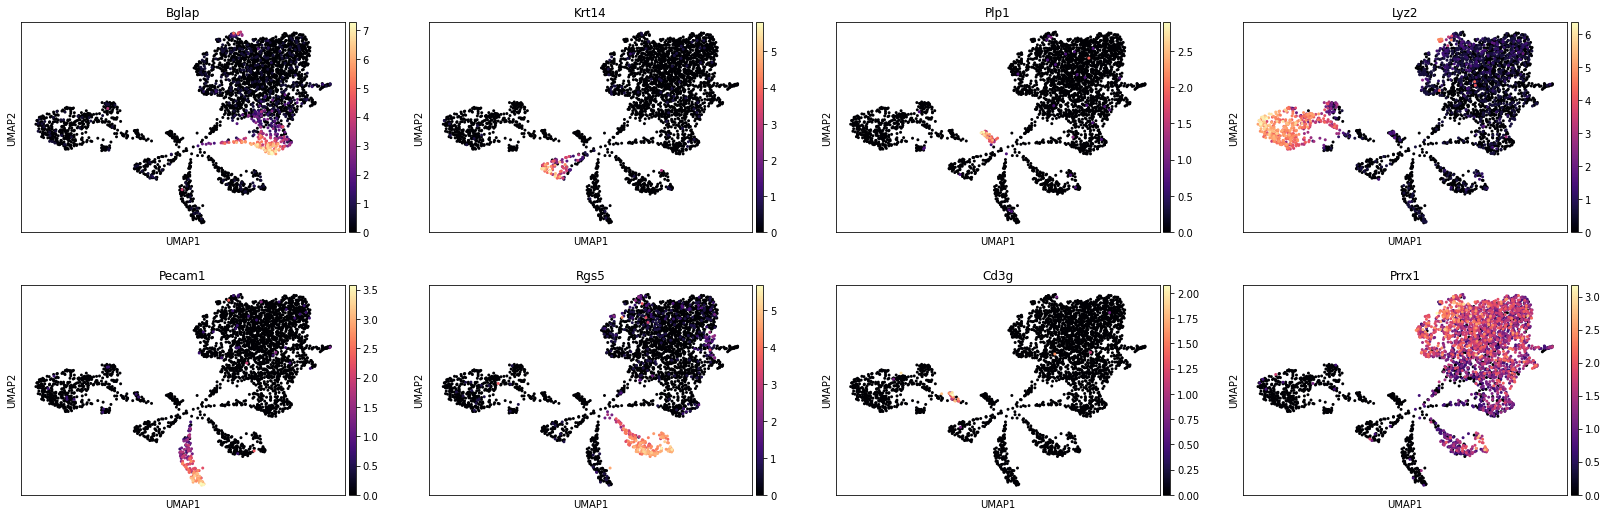

In [28]:
sc.pp.pca(adata_12dpa)
sc.pp.neighbors(adata_12dpa)
sc.tl.umap(adata_12dpa)
sc.pl.umap(adata_12dpa, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [29]:
sc.tl.leiden(adata_12dpa_hvg, resolution=0.6)
adata_12dpa.obs['leiden'] = adata_12dpa_hvg.obs['leiden']

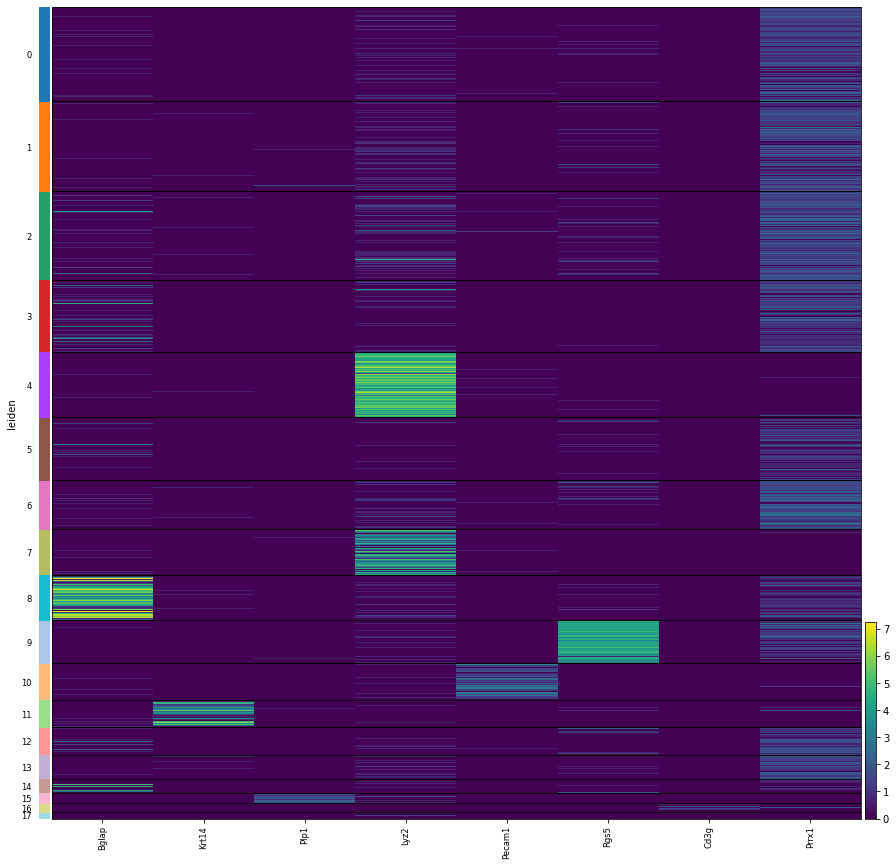

In [30]:
sc.pl.heatmap(adata_12dpa, gene_symbols='Name', var_names=marker_genes, groupby='leiden', figsize=(15,15))

### K-means clustering

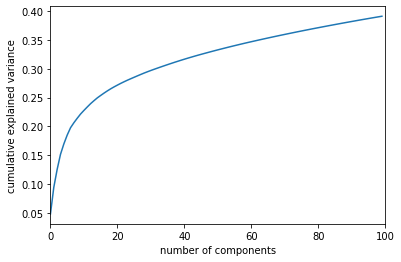

In [31]:
explained_variance_ratio(adata_12dpa_hvg)

30 can be said to be the point of diminishing returns.

In [32]:
reduced_data_12dpa_hvg = TruncatedSVD(n_components=30).fit_transform(adata_12dpa_hvg.X)

In [33]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(reduced_data_12dpa_hvg) 
adata_12dpa.obs['kmeans15'] = kmeans.labels_.astype(str)

... storing 'kmeans15' as categorical


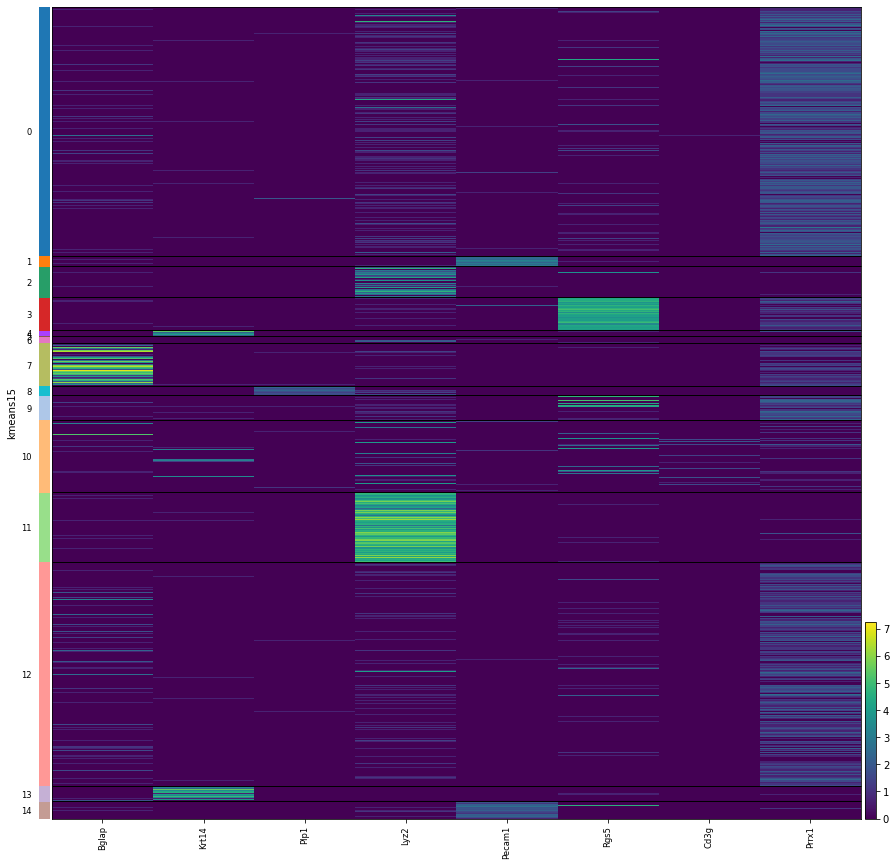

In [34]:
sc.pl.heatmap(adata_12dpa, gene_symbols='Name', var_names=marker_genes, groupby='kmeans15', figsize=(15,15))

In [35]:
dir_path = os.path.dirname(os.path.realpath('paper_2.ipynb'))
adata_11dpa_hvg.write(os.path.join(dir_path, 'adata_11dpa_hvg'))

# 14dpa

... storing 'Name' as categorical


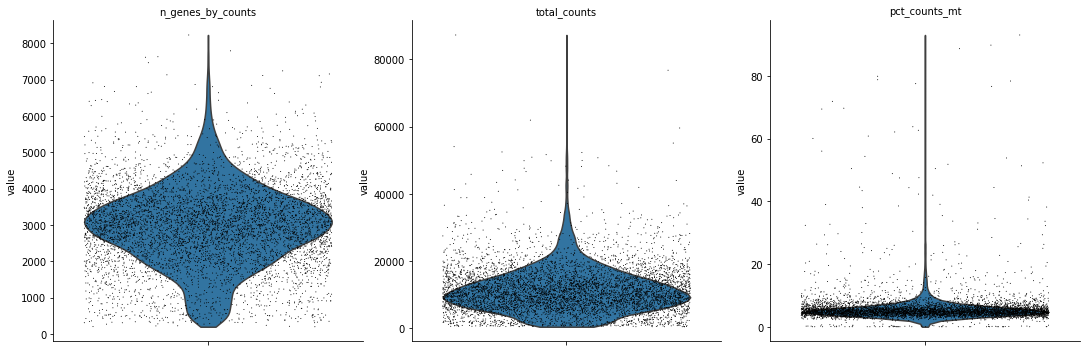

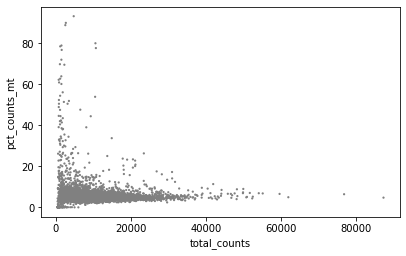

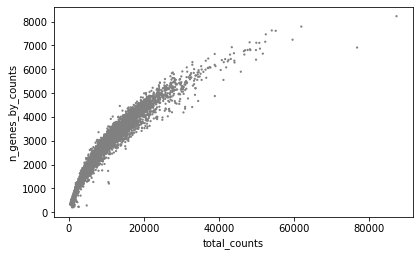

In [36]:
adata_14dpa = adatas[3].copy()
adata_14dpa.var_names_make_unique

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_14dpa.X = adata_14dpa.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_14dpa, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_14dpa, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_14dpa.var['mt'] = adata_14dpa.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_14dpa, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata_14dpa, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_14dpa, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_14dpa, x='total_counts', y='n_genes_by_counts')

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


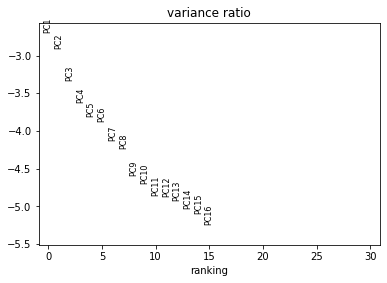

In [37]:
adata_14dpa.obs['n_genes_by_counts_filter'] = adata_14dpa.obs.n_genes_by_counts < 1000
adata_14dpa.obs['pct_counts_mt_filter'] = adata_14dpa.obs.pct_counts_mt < 5

sc.pp.log1p(adata_14dpa)
sc.pp.highly_variable_genes(adata_14dpa, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_14dpa_hvg = adata_14dpa[:, adata_14dpa.var['highly_variable'] == True]
adata_14dpa_hvg.raw = adata_14dpa
sc.pp.scale(adata_14dpa_hvg)
sc.pp.pca(adata_14dpa_hvg, n_comps=16)
sc.pp.neighbors(adata_14dpa_hvg)
sc.pl.pca_variance_ratio(adata_14dpa_hvg, log=True)

## Clustering¶
### Visualizing marker genes

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


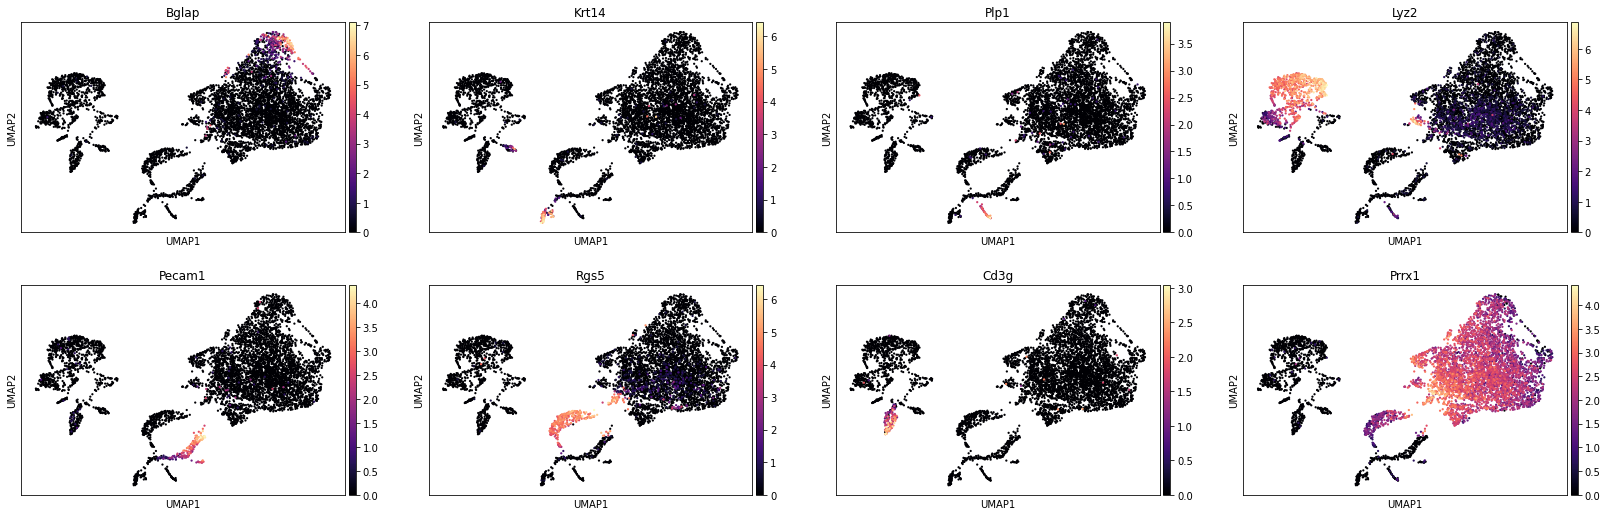

In [38]:
sc.pp.pca(adata_14dpa)
sc.pp.neighbors(adata_14dpa)
sc.tl.umap(adata_14dpa)
sc.pl.umap(adata_14dpa, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [39]:
sc.tl.leiden(adata_14dpa_hvg, resolution=0.6)
adata_14dpa.obs['leiden'] = adata_14dpa_hvg.obs['leiden']

### K-means clustering

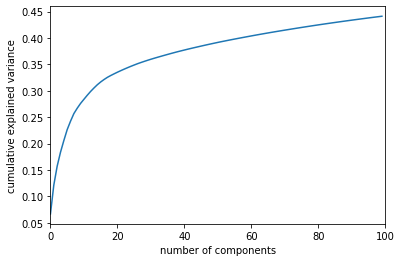

In [40]:
explained_variance_ratio(adata_14dpa_hvg)

In [41]:
reduced_data_14dpa_hvg = TruncatedSVD(n_components=30).fit_transform(adata_14dpa_hvg.X)

In [42]:
kmeans = KMeans(n_clusters=19, random_state=0).fit(reduced_data_14dpa_hvg) 
adata_14dpa.obs['kmeans19'] = kmeans.labels_.astype(str)

... storing 'kmeans19' as categorical


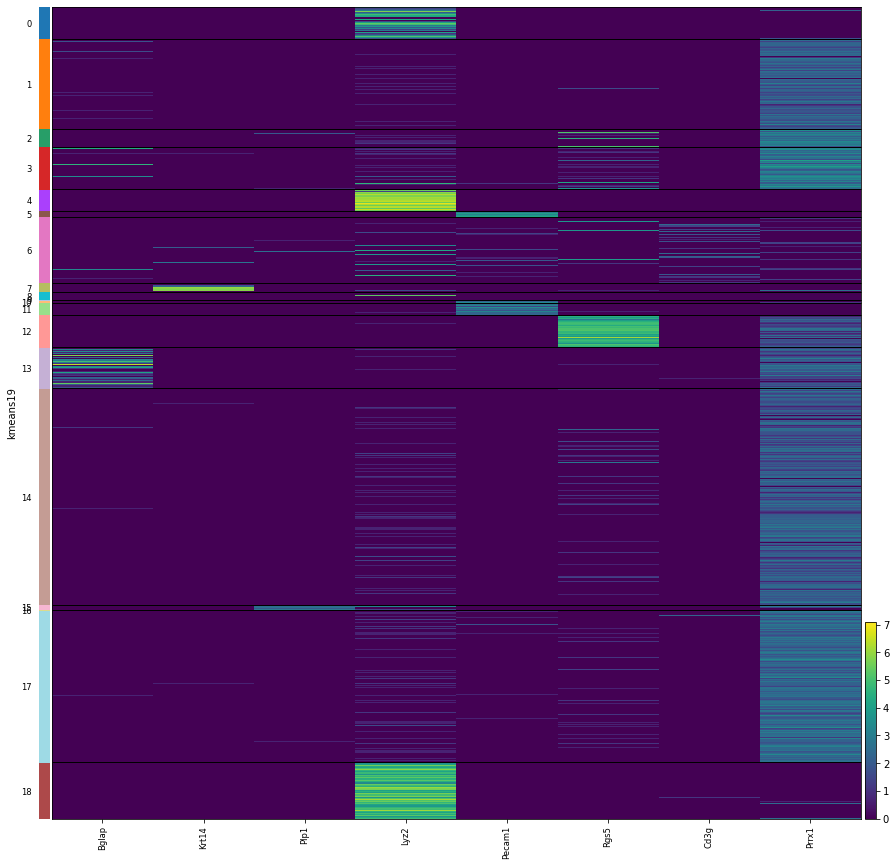

In [43]:
sc.pl.heatmap(adata_14dpa, gene_symbols='Name', var_names=marker_genes, groupby='kmeans19', figsize=(15,15))

In [44]:
dir_path = os.path.dirname(os.path.realpath('paper_2.ipynb'))
adata_14dpa_hvg.write(os.path.join(dir_path, 'adata_14dpa_hvg'))

# 17dpa

... storing 'Name' as categorical


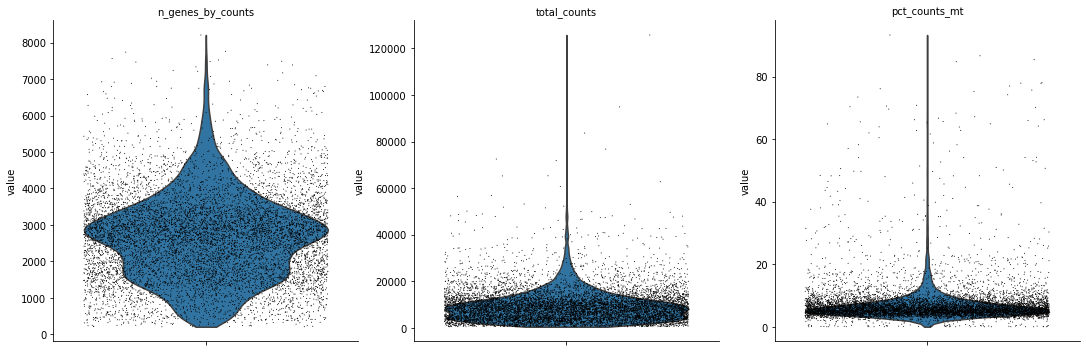

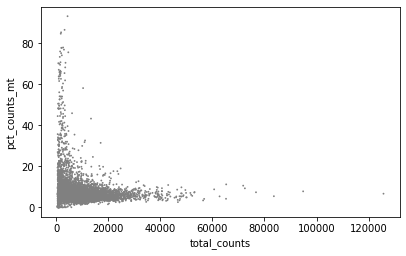

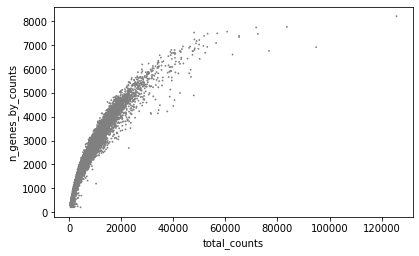

In [45]:
adata_17dpa = adatas[4].copy()
adata_17dpa.var_names_make_unique

# convert COOrdinate matrix to CSR matrix for matrix vector operations
adata_17dpa.X = adata_17dpa.X.tocsr()

# filter cells per number of genes
sc.pp.filter_cells(adata_17dpa, min_genes=200)
# filter genes per number of cells
sc.pp.filter_genes(adata_17dpa, min_cells=3)

# annotate the group of mitochondrial genes as 'mt'
adata_17dpa.var['mt'] = adata_17dpa.var['Name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata_17dpa, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata_17dpa, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_17dpa, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_17dpa, x='total_counts', y='n_genes_by_counts')

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


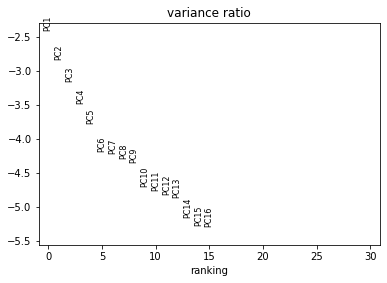

In [46]:
adata_17dpa.obs['n_genes_by_counts_filter'] = adata_17dpa.obs.n_genes_by_counts < 2500
adata_17dpa.obs['pct_counts_mt_filter'] = adata_17dpa.obs.pct_counts_mt < 5

sc.pp.log1p(adata_17dpa)
sc.pp.highly_variable_genes(adata_17dpa, min_mean=0.0125, max_mean=4, min_disp=0.5, n_top_genes=3000)

adata_17dpa_hvg = adata_17dpa[:, adata_17dpa.var['highly_variable'] == True]
adata_17dpa_hvg.raw = adata_17dpa
sc.pp.scale(adata_17dpa_hvg)
sc.pp.pca(adata_17dpa_hvg, n_comps=16)
sc.pp.neighbors(adata_17dpa_hvg)
sc.pl.pca_variance_ratio(adata_17dpa_hvg, log=True)

## Clustering
### Visualizing marker genes

/home/jafar_isbarov/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


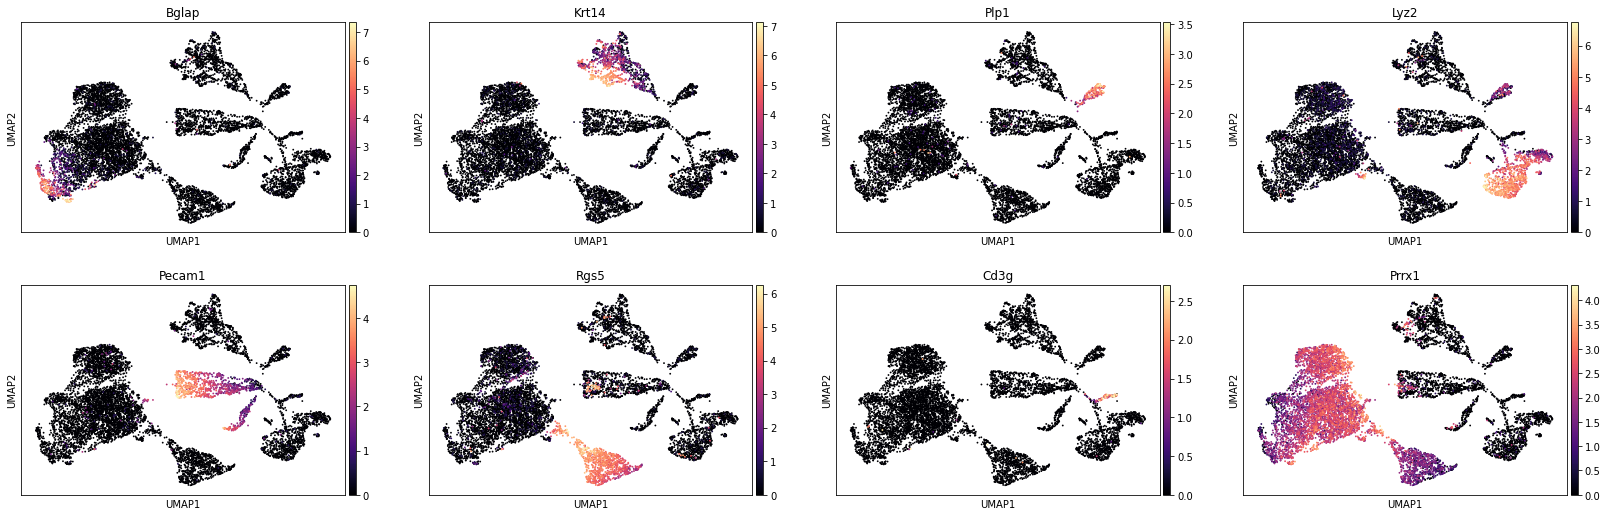

In [47]:
sc.pp.pca(adata_17dpa)
sc.pp.neighbors(adata_17dpa)
sc.tl.umap(adata_17dpa)
sc.pl.umap(adata_17dpa, gene_symbols='Name', color=marker_genes, color_map='magma', use_raw=False, show=True)

### Graph clustering

In [48]:
sc.tl.leiden(adata_17dpa_hvg, resolution=0.6)
adata_17dpa.obs['leiden'] = adata_17dpa_hvg.obs['leiden']

### K-means clustering

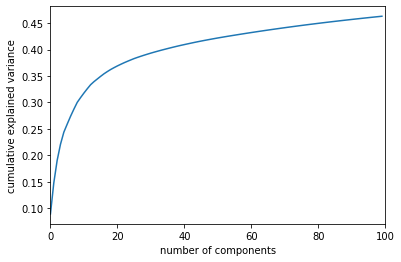

In [49]:
explained_variance_ratio(adata_17dpa_hvg)

In [50]:
reduced_data_17dpa_hvg = TruncatedSVD(n_components=30).fit_transform(adata_17dpa_hvg.X)

In [51]:
kmeans = KMeans(n_clusters=17, random_state=0).fit(reduced_data_17dpa_hvg) 
adata_17dpa.obs['kmeans17'] = kmeans.labels_.astype(str)

... storing 'kmeans17' as categorical


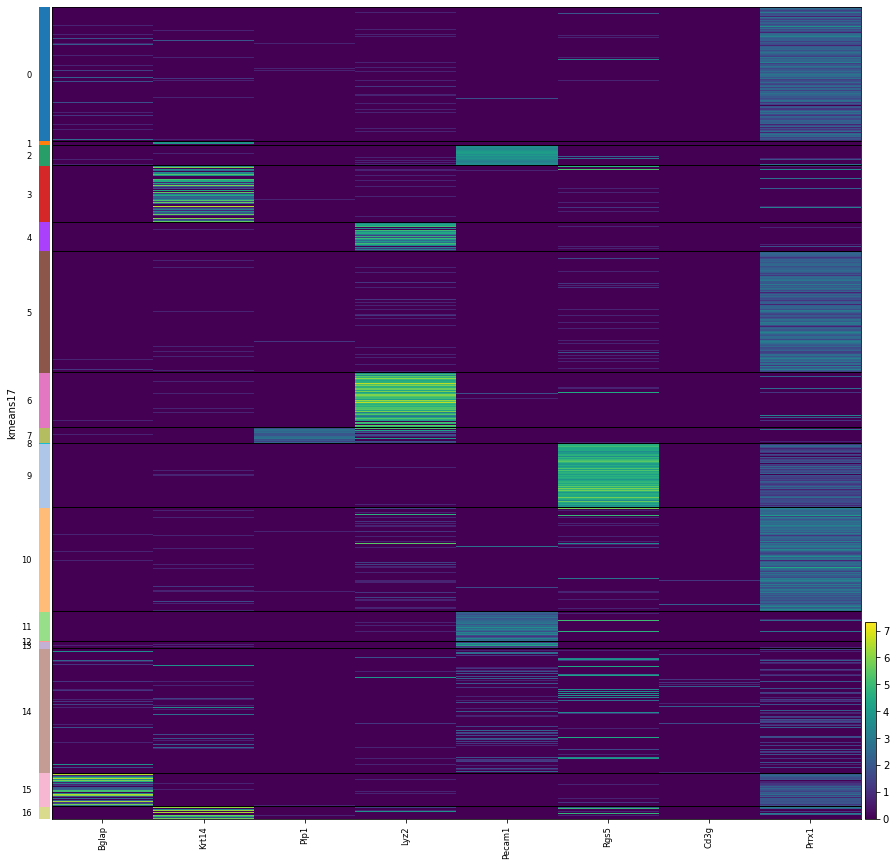

In [52]:
sc.pl.heatmap(adata_17dpa, gene_symbols='Name', var_names=marker_genes, groupby='kmeans17', figsize=(15,15))

In [53]:
dir_path = os.path.dirname(os.path.realpath('paper_2.ipynb'))
adata_17dpa_hvg.write(os.path.join(dir_path, 'adata_17dpa_hvg'))